# Trading Strategy Design
This file is aimed to practice, train and learn from designing the first few trading strategies in this project. 

In [3]:
# packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys

sys.path.append('/Users/zway/Desktop/BTC_Project/Crypto_Research/features')
from trend_indicator_pipeline_pkg import MovingAveragePipeline, MomentumIndicatorPipeline, VolatilityIndicatorPipeline

from arcticdb.version_store.helper import ArcticMemoryConfig

from arcticdb import Arctic

In [4]:
# Load files
df = pd.read_csv('/Users/zway/Desktop/BTC_Project/raw_datasets/BTCUSD_1m_2023.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.set_index('Timestamp', inplace=True)

# DB path
DB_PATH = '/Users/zway/Desktop/BTC_Project/DB'

In [5]:
# indicators simplify
trend = MovingAveragePipeline(lib_name='trend_indicators', store_path=f"lmdb://{DB_PATH}")
momentum = MomentumIndicatorPipeline(lib_name='momentum_indicators', store_path=f"lmdb://{DB_PATH}")
volatility = VolatilityIndicatorPipeline(lib_name='volatility_indicators', store_path=f"lmdb://{DB_PATH}")

20250706 17:11:08.144348 15660293 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[81846]
20250706 17:11:08.147972 15660293 W arcticdb | LMDB path at /Users/zway/Desktop/BTC_Project/DB/ has already been opened in this process which is not supported by LMDB. You should only open a single Arctic instance over a given LMDB path. To continue safely, you should delete this Arctic instance and any others over the LMDB path in this process and then try again. Current process ID=[81846]


## 1st Strategy
Indicators: SMA, EMA, RSI, MACD and Bollinger Bands

### Entry Signal
Price above EMA 20 (uptrend)

MACD > MACD Signal (positive momentum)

RSI > 50 (strong buying pressure)

Price touches or crosses above the Lower Bollinger Band (volatility cue)

### Exit Signal
Price drops below EMA 20

OR MACD < MACD Signal

OR RSI < 45

OR Price touches or crosses below Upper Bollinger Band



In [6]:
# Set up indicators

#EMA
df = trend.compute_ema(df, days = 20)

# MACD - Standard: fast_days=12, slow_days=26, signal_days=9
df = momentum.compute_macd(df, 12, 26, 9)
df.rename(columns={
    'macd': 'macd_12_26',
    'macd_signal': 'macd_sig_12_26',
    'macd_diff': 'macd_hist_12_26'
}, inplace=True)

# RSI
df = momentum.compute_rsi(df, days=14)

# Bollinger Bands
df = volatility.compute_bollinger_bands(df, days=20, std=2)

In [12]:
# Strategy Setup
def run_strategy(df, initial_cash=10000):
    cash = initial_cash
    position = 0
    entry_price = 0
    portfolio = []
    signals = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Entry condition
        if position == 0:
            if (
                row['Close'] > row['ema_20d']
                and row['macd_12_26'] > row['macd_sig_12_26']
                and row['rsi_14d'] > 50
                and row['Close'] <= row['bb_lower_20d']
            ):
                position = cash / row['Close']
                entry_price = row['Close']
                cash = 0
                signals.append((row.name, 'Buy', row['Close']))

        # Exit condition
        elif position > 0:
            if (
                row['Close'] < row['ema_20d']
                or row['macd_12_26'] < row['macd_sig_12_26']
                or row['rsi_14d'] < 45
                or row['Close'] >= row['bb_upper_20d']
            ):
                cash = position * row['Close']
                position = 0
                signals.append((row.name, 'Sell', row['Close']))

        total_value = cash if position == 0 else position * row['Close']
        portfolio.append(total_value)

    df = df.iloc[1:].copy()
    df['portfolio_value'] = portfolio
    return df, signals


In [9]:
# Visualize Portfolio & Signals
def plot_portfolio(df, signals):
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, df['portfolio_value'], label='Portfolio Value')
    plt.plot(df.index, df['Close'], label='BTC Price', alpha=0.5)

    for ts, signal, price in signals:
        if signal == 'Buy':
            plt.scatter(ts, price, color='green', marker='^', label='Buy Signal')
        elif signal == 'Sell':
            plt.scatter(ts, price, color='red', marker='v', label='Sell Signal')

    plt.title('BTC/USD Strategy Backtest')
    plt.xlabel('Timestamp')
    plt.ylabel('USD')
    plt.legend()
    plt.tight_layout()
    plt.show()

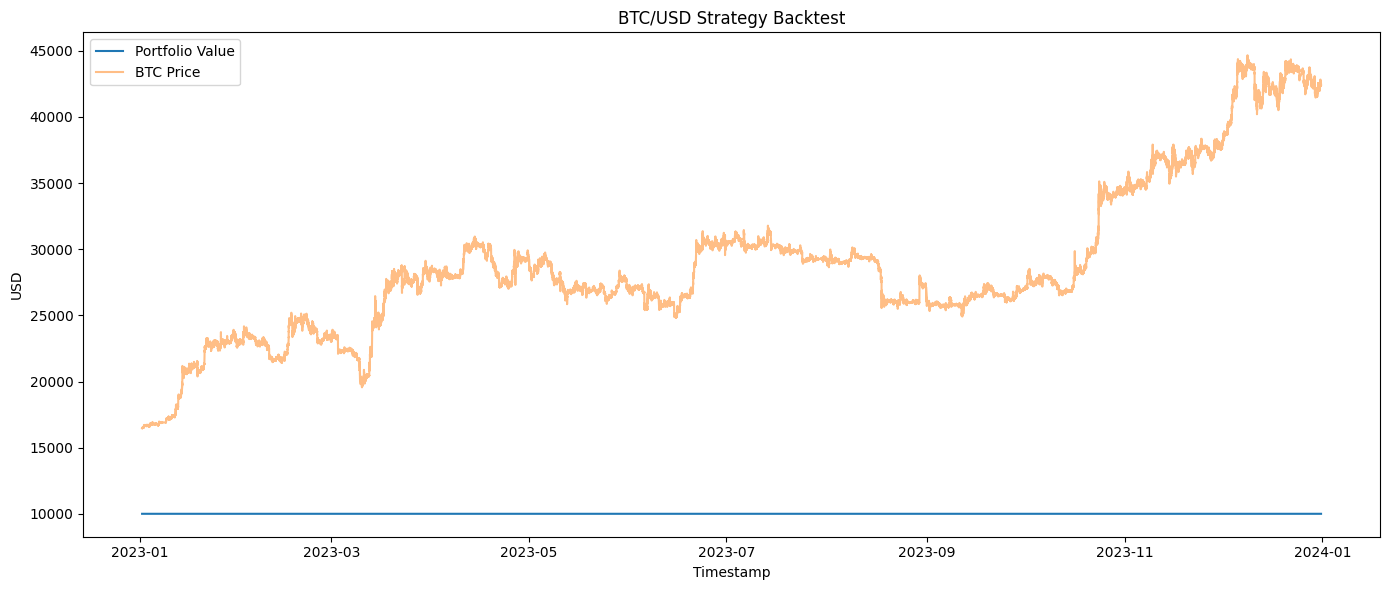

In [13]:
# Run the strategy
result_df, trade_signals = run_strategy(df)

# Plot results
plot_portfolio(result_df, trade_signals)

## Result & Common
There is no trade has been executed, the strategy's entry condition was too restrictive or rarely satisfied over the dataset.

## 2nd Strategy - Aggressive Entry Strategy
Indicators: SMA, EMA, RSI, MACD and Bollinger Bands

### Entry Signal
Price above EMA 20 (uptrend)

MACD histogram > 0 (positive momentum)

RSI > 45 (strong buying pressure)


### Exit Signal
Price drops below EMA 20

OR MACD < MACD Signal

OR RSI < 45

OR Price touches or crosses below Upper Bollinger Band

In [16]:
# Aggressive-1 Strategy Setup
def run_agg_strategy(df, initial_cash=10000):
    cash = initial_cash
    position = 0
    entry_price = 0
    portfolio = []
    signals = []

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]

        # Entry condition
        if position == 0:
            if (
                row['Close'] > row['ema_20d']
                and row['macd_hist_12_26'] > 0
                and row['rsi_14d'] >= 45
            ):
                position = cash / row['Close']
                entry_price = row['Close']
                cash = 0
                signals.append((row.name, 'Buy', row['Close']))

        # Exit condition
        elif position > 0:
            if (
                row['Close'] < row['ema_20d']
                or row['macd_12_26'] < row['macd_sig_12_26']
                or row['rsi_14d'] < 45
                or row['Close'] >= row['bb_upper_20d']
            ):
                cash = position * row['Close']
                position = 0
                signals.append((row.name, 'Sell', row['Close']))

        total_value = cash if position == 0 else position * row['Close']
        portfolio.append(total_value)

    df = df.iloc[1:].copy()
    df['portfolio_value'] = portfolio
    return df, signals


In [17]:
# Run the strategy
result_df, trade_signals = run_agg_strategy(df)

# Plot results
plot_portfolio(result_df, trade_signals)

/var/folders/17/9z6k3ymn2q36ng2sbdl_60zh0000gn/T/ipykernel_81846/3388497894.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/17/9z6k3ymn2q36ng2sbdl_60zh0000gn/T/ipykernel_81846/3388497894.py:17: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
/opt/anaconda3/envs/de_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: Image size of 1178x786517 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 1400x600 with 1 Axes>

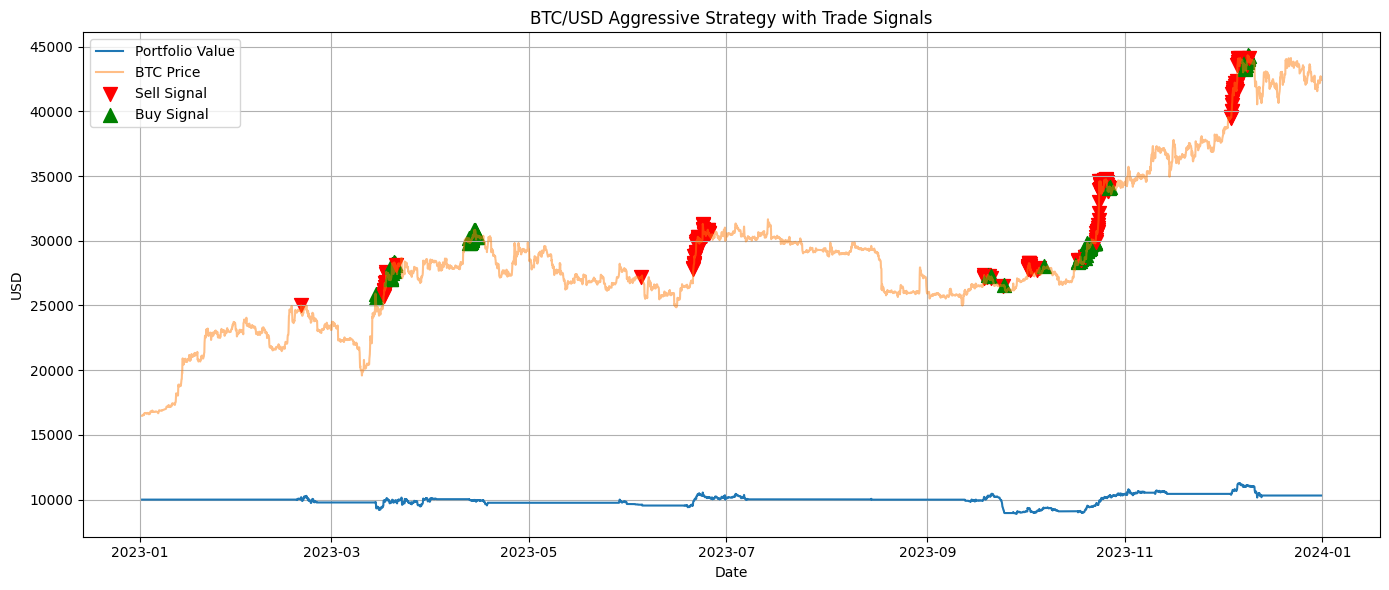

In [20]:
plot_df = result_df.iloc[::100, :]         # Downsample for plotting

plt.figure(figsize=(14, 6))
plt.plot(plot_df.index, plot_df['portfolio_value'], label='Portfolio Value')
plt.plot(plot_df.index, plot_df['Close'], label='BTC Price', alpha=0.5)

# Add Buy/Sell markers
for ts, action, price in trade_signals:
    if ts in plot_df.index:
        if action == 'Buy':
            plt.scatter(ts, price, marker='^', color='green', s=100, label='Buy Signal')
        elif action == 'Sell':
            plt.scatter(ts, price, marker='v', color='red', s=100, label='Sell Signal')

# Deduplicate legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())

# Final plot config
plt.title('BTC/USD Aggressive Strategy with Trade Signals')
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid(True)
plt.tight_layout()
plt.show()

In [21]:
def summarize_portfolio(df, signals, initial_cash=10000, periods_per_year=252):
    final_value = df['portfolio_value'].iloc[-1]
    returns = df['portfolio_value'].pct_change().dropna()

    # Basic stats
    profit = final_value - initial_cash
    total_return = profit / initial_cash
    n_trades = len([s for s in signals if s[1] == 'Buy'])

    # Win rate
    profits = []
    in_trade = False
    for i, (ts, action, price) in enumerate(signals):
        if action == 'Buy':
            entry = price
            in_trade = True
        elif action == 'Sell' and in_trade:
            profits.append(price - entry)
            in_trade = False
    win_rate = np.mean([p > 0 for p in profits]) if profits else np.nan

    # Sharpe ratio
    sharpe = (returns.mean() / returns.std()) * np.sqrt(periods_per_year) if not returns.empty else np.nan

    # Max drawdown
    peak = df['portfolio_value'].cummax()
    drawdown = (df['portfolio_value'] - peak) / peak
    max_drawdown = drawdown.min()

    # Display
    summary = {
        'Initial Capital': f'${initial_cash:,.2f}',
        'Final Portfolio Value': f'${final_value:,.2f}',
        'Net Profit': f'${profit:,.2f}',
        'Total Return': f'{total_return:.2%}',
        'Number of Trades': n_trades,
        'Win Rate': f'{win_rate:.2%}' if not np.isnan(win_rate) else 'N/A',
        'Max Drawdown': f'{max_drawdown:.2%}' if not np.isnan(max_drawdown) else 'N/A',
        'Sharpe Ratio': f'{sharpe:.2f}' if not np.isnan(sharpe) else 'N/A'
    }

    for k, v in summary.items():
        print(f'{k:25s}: {v}')

In [22]:
summarize_portfolio(result_df, trade_signals)

Initial Capital          : $10,000.00
Final Portfolio Value    : $10,315.71
Net Profit               : $315.71
Total Return             : 3.16%
Number of Trades         : 18774
Win Rate                 : 50.45%
Max Drawdown             : -16.05%
Sharpe Ratio             : 0.01


## Result & Comments
### Portfolio Snapshot
The trade strategy is working but the gain is marginal. The return rate does not beat federal rate, and the sharpe ratio is very low, which implies that the earning is properly brought by noise instead of true earning. Considering the BTC price has increase drastically in this 1 year period. This result is unacceptable. 

### Thoughts
#### Unrealistic Frequent Trade
The numbers of trade is 18774, and on the graph, we can find the trading signals, whether entry/exit are very condensed. The strategy is frequently been triggered on low signals.

#### Short Holding Period
BTC rallied from ~$17K → ~$42K, but the portfolio grew just 3.16%. Based on the graph, I think this may be caused by short holding period and whipsaws(frequent buy/sell with no profit)

#### Risk
The Sharpe Ratio is 0.01, which means returns are mostly noise, not a signal-driven edge. It is not meaningful to discuss the risk here.

### Future Improvement
#### Debounce Trading Frequency
- Enforce a minimum holding period for now, just to test: Add a flag: hold_counter += 1 and don't allow exits before hold_counter >= N

#### Filter Entry Signals
- Add SMA confirmation (e.g., EMA_20 > SMA_50)

- Add RSI slope check: RSI must be rising for buy signal

- Ensure MACD histogram is increasing (macd_hist[t] > macd_hist[t-1])

#### Add Stop Loss / Take Profit
Example: Exit if price drops >5% or gains >10% since entry

Improves drawdown control and lets winners run
